#MLP MNIST AE

## Installation and imports

In [ ]:
!mkdir figures
!mkdir scripts
%cd /content/scripts
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/lvm_plots_utils.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-mlp-latent-dim-2.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-mlp-latent-dim-20.ckpt
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/ae_mnist_mlp.py

/content/scripts


In [ ]:
%%capture
! pip install --quiet torchvision pytorch-lightning torch test-tube einops umap

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer
from einops import rearrange
import seaborn as sns
from lvm_plots_utils import get_random_samples, get_grid_samples, plot_scatter_plot, get_imrange, plot_grid_plot
from torchvision.utils import make_grid
from pytorch_lightning.utilities.seed import seed_everything
from ae_mnist_mlp import BasicAEModule

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
mnist_full = MNIST(".", download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

dm = DataLoader(mnist_full, batch_size=512, shuffle=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Basic MLP AE Module

In [ ]:
ae = BasicAEModule(20)
ae.load_state_dict(torch.load("ae-mnist-mlp-latent-dim-20.ckpt"))
ae.to(device)

BasicAEModule(
  (vae): AE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
    )
    (fc_mu): Linear(in_features=512, out_features=20, bias=True)
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [ ]:
ae2 = BasicAEModule(2)
ae2.load_state_dict(torch.load("ae-mnist-mlp-latent-dim-2.ckpt"))
ae2.to(device)

BasicAEModule(
  (vae): AE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
    )
    (fc_mu): Linear(in_features=512, out_features=2, bias=True)
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

## Reconstruction

### MLP-AE with latent dim 20

In [ ]:
batch = next(iter(dm))
imgs, _ = batch
imgs = imgs[:16]
img_size = 28

torch.Size([16, 1, 28, 28])


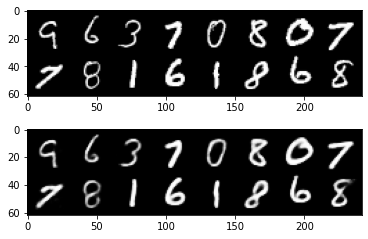

In [ ]:
def reconstruct(img):
    return ae(rearrange(imgs, "b c h w -> b ( c h w)")).reshape(-1, 1, img_size, img_size)


fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs).cpu(), "c h w -> h w c"))
imgs = imgs.to(device=device)
ae = ae.to(device)
print(reconstruct(imgs).shape)
axs[1].imshow(rearrange(make_grid(reconstruct(imgs)).cpu(), "c h w -> h w c"))
plt.show()

### MLP-AE with latent dim 2

In [ ]:
batch = next(iter(dm))
imgs, _ = batch
imgs = imgs[:16]
img_size = 28

torch.Size([16, 1, 28, 28])


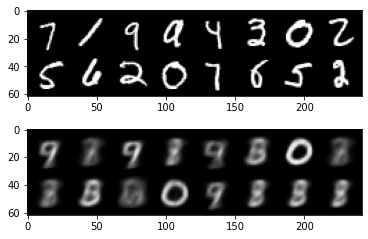

In [ ]:
def reconstruct(img):
    return ae2(rearrange(imgs, "b c h w -> b ( c h w)")).reshape(-1, 1, img_size, img_size)


fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs).cpu(), "c h w -> h w c"))
imgs = imgs.to(device=device)
ae2 = ae2.to(device)
print(reconstruct(imgs).shape)
axs[1].imshow(rearrange(make_grid(reconstruct(imgs)).cpu(), "c h w -> h w c"))
plt.show()

## Sampling

### Random samples from truncated normal distribution 

We sample $z \sim TN(0,1)$ form a truncated normal distribution with a threshold = 5


#### MLP-AE with latent dim 20

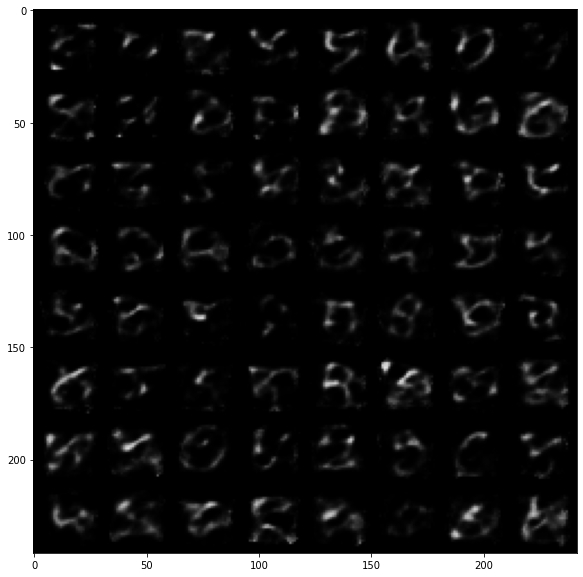

In [ ]:
def decoder(z):
    return ae.vae.decoder(z).reshape(-1, 1, img_size, img_size)


plt.figure(figsize=(10, 10))
# Where 5 is the truncation threshold for our truncated normal distribution we are sampling from
imgs = get_random_samples(decoder, 5)
plt.imshow(imgs)

#### MLP-AE with latent dim 2

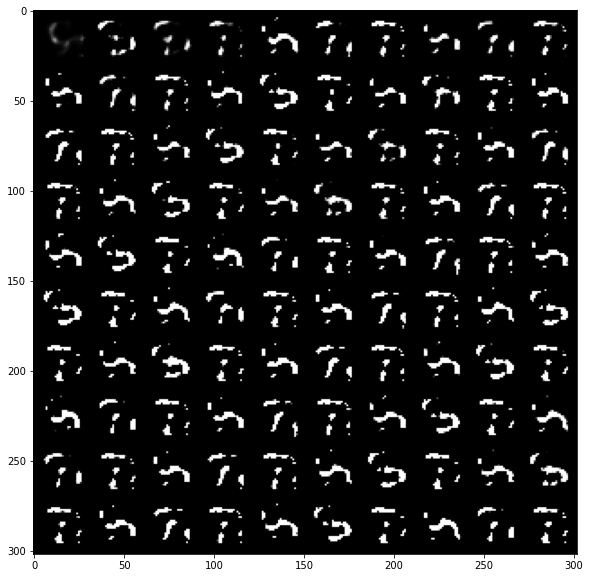

In [ ]:
def decoder(z):
    return ae.vae.decoder(z).reshape(-1, img_size, img_size)


plt.figure(figsize=(10, 10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 10), 10), " c h w -> h w c").cpu().detach())

### Grid Sampling

#### MLP-AE with latent dim 20

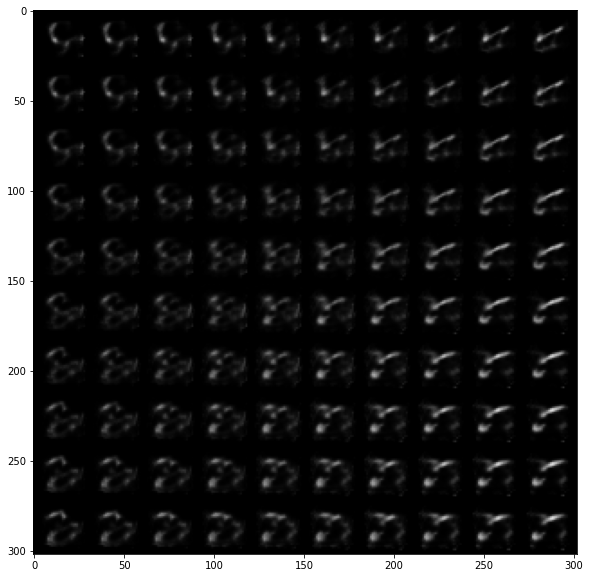

In [ ]:
def decoder(z):
    return m.vae.decoder(z).reshape(-1, img_size, img_size)


plt.figure(figsize=(10, 10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, latent_size=20), 10), " c h w -> h w c").cpu().detach())

#### MLP-AE with latent dim 2

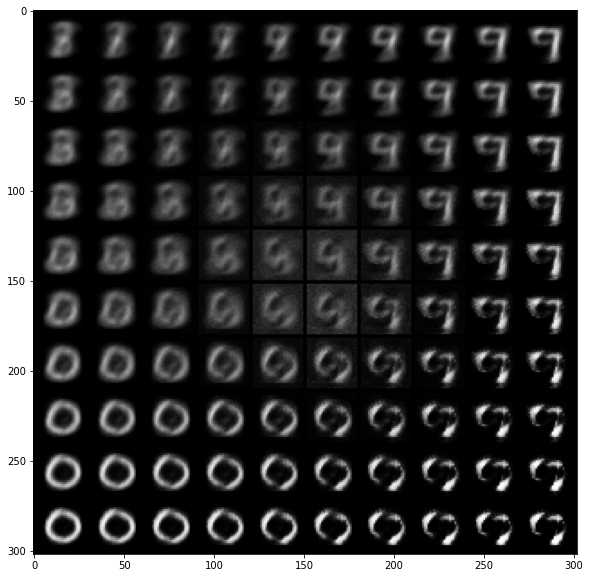

In [ ]:
def decoder(z):
    return ae2.vae.decoder(z).reshape(-1, img_size, img_size)


plt.figure(figsize=(10, 10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 5), 10), " c h w -> h w c").cpu().detach())

## 2D Latent Embeddings For MNIST

### MLP-AE with latent dim 20

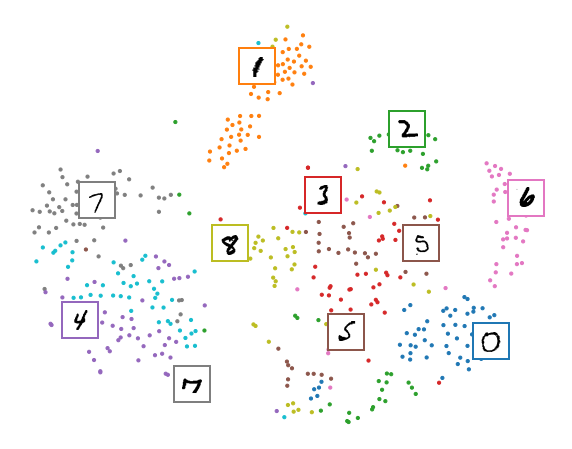

In [ ]:
def encoder(img):
    return ae.vae.encode(rearrange(img, "b c h w -> b ( c h w)"))


plot_scatter_plot(batch, encoder)

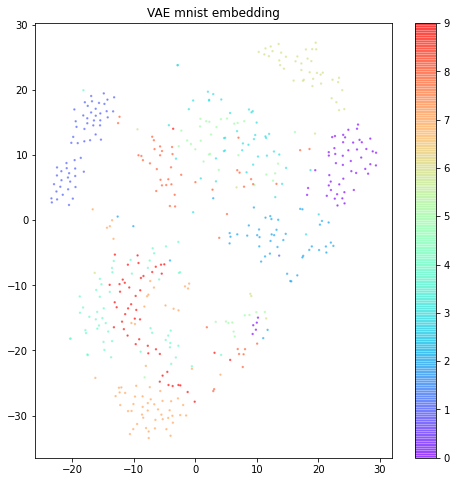

In [ ]:
plot_grid_plot(batch, encoder)

### MLP-AE with latent dim 2

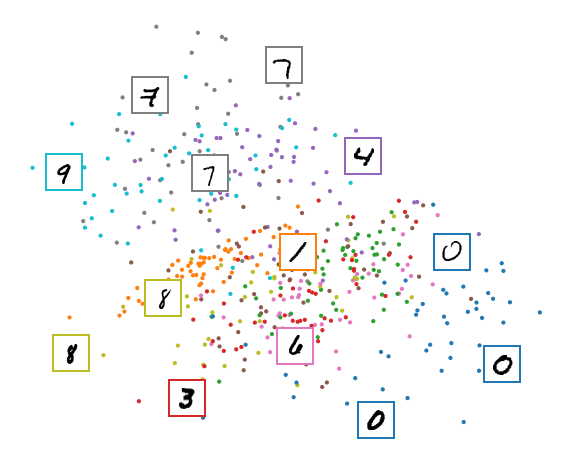

In [ ]:
def encoder(img):
    return ae2.vae.encode(rearrange(img, "b c h w -> b ( c h w)")).cpu().detach().numpy()


plot_scatter_plot(batch, encoder)

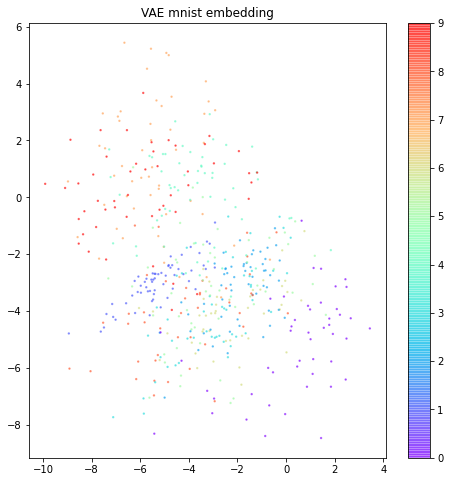

In [ ]:
plot_grid_plot(batch, encoder)

## Interpolation

### Spherical Interpolation

#### MLP-AE with latent dim 20

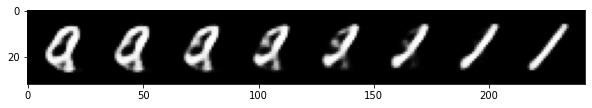

In [ ]:
def decoder(z):
    return ae.vae.decoder(z).reshape(-1, img_size, img_size)


def encoder(img):
    return ae.vae.encode(rearrange(img, "b c h w -> b ( c h w)"))


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10, 100))
arr = get_imrange(decoder, start, end)
plt.imshow(arr)

#### MLP-AE with latent dim 2

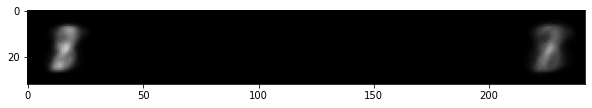

In [ ]:
def decoder(z):
    return ae2.vae.decoder(z).reshape(-1, img_size, img_size)


def encoder(img):
    return ae2.vae.encode(rearrange(img, "b c h w -> b ( c h w)"))


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10, 100))
arr = get_imrange(decoder, start, end)
plt.imshow(arr)

### Linear Interpolation

#### MLP-AE with latent dim 20

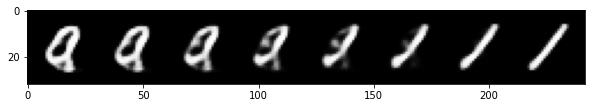

In [ ]:
def decoder(z):
    return ae.vae.decoder(z).reshape(-1, img_size, img_size)


def encoder(img):
    return ae.vae.encode(rearrange(img, "b c h w -> b ( c h w)"))


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10, 100))
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)

#### MLP-AE with latent dim 2

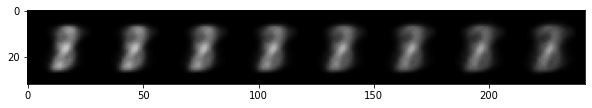

In [ ]:
def decoder(z):
    return ae2.vae.decoder(z).reshape(-1, img_size, img_size)


def encoder(img):
    return ae2.vae.encode(rearrange(img, "b c h w -> b ( c h w)"))


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10, 100))
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)